The aim of this notebook is
1. to find the threshold for statistical filtering of Pseudo-Labels
2. to find whether a custom impl. of corner calculation for a bbox is the same the one used in pixor official

In [1]:
import os
from pathlib import Path
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader

home = os.path.join(os.path.expanduser("~"), "buni")

dataset_path = os.path.join(home, "dataset", "av2", "train")
dataset_path = Path(dataset_path)
dataloader = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_id = 'ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd'

print(f"Scene {scene_id} has {len(dataloader.get_ordered_log_lidar_timestamps(scene_id))} frames")

Scene ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd has 157 frames


In [36]:
# frame_id = 315968449159644000
frame_idx = 80
frame_id = dataloader.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]

print(f"Scene selected: {scene_id},\nFrame selected: {frame_id}")

Scene selected: ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd,
Frame selected: 315968343159753000


In [37]:
from av2.structures.sweep import Sweep

frame_path = dataloader.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)
sweep = Sweep.from_feather(frame_path)

points = sweep.xyz

+ Ground and non_ground points, even in dataframe, are stored in float64


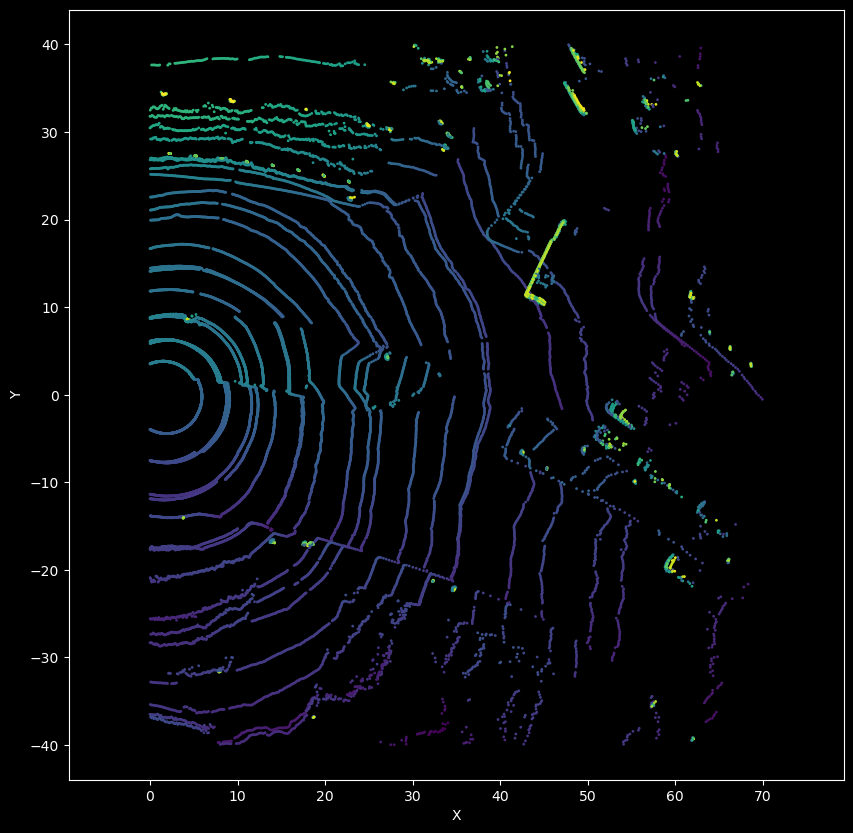

In [38]:
from prototype_utils import *

plot_bev_dark(filter_roi(points))

In [39]:
load_refined_path = os.path.join(home, "output-data","av2","refined_bboxes", scene_id)

In [ ]:
import pandas as pd
refined_bboxes = pd.read_feather(os.path.join(load_refined_path, f"{frame_id}.feather")).to_numpy()

In [ ]:
from prototype_utils import get_bbox_corners

refined_corners = [get_bbox_corners(bbox) for bbox in refined_bboxes]
refined_corners = np.stack(refined_corners)

In [43]:
from shapely.geometry import Polygon
import numpy as np

def filter_bboxes_on_area(corners: np.ndarray, percentile=0.6, area_upper_threshold=80) ->np.ndarray:
    """
    Filter out bounding boxes that have an area less than a certain threshold
    
    Args:
        corners: A numpy array of shape (n, 4, 2) containing the four corners of the bounding boxes
        percentile: The percentile of the area to use as the threshold
        area_threshold: The threshold area in square units
        
    Returns:
        A numpy array of shape (m, 4, 2) containing the bounding boxes that meet the threshold
    """
    areas = [Polygon(corners[i]).area for i in range(corners.shape[0])]
    area_lower_bound = np.percentile(areas, percentile)
    
    
    filtered_corners = []
    for idx, corner in enumerate(corners):
        poly = Polygon(corner)
        if poly.area > area_lower_bound and poly.area <= area_upper_threshold:
            filtered_corners.append(corner)
            
    filtered_corners = np.stack(filtered_corners)
    
    return filtered_corners

In [ ]:
refined_corners2 = filter_bboxes_on_area(refined_corners)

In [45]:
def plot_bboxes_on_point_cloud(points_roi, label_corners):
    """
    Visualize bounding boxes on a point cloud using matplotlib.

    Parameters:
    - label_df: DataFrame containing bounding box parameters.
    - points_roi: Nx3 array representing the point cloud data in [x, y, z] format.
    """
    # Get the x and y points for the point cloud visualization
    x_points = points_roi[:, 0]
    y_points = points_roi[:, 1]
    
    # Plot point cloud
    plt.figure(figsize=(10, 10))
    plt.scatter(x_points, y_points, s=1, color='blue', label='Point Cloud')
    
    # Plot each bounding box
    for bbox_corners in label_corners:
        # Close the box by repeating the first corner at the end
        bbox_corners = np.vstack((bbox_corners, bbox_corners[0]))
        plt.plot(bbox_corners[:, 0], bbox_corners[:, 1], color='red', linewidth=2)
    
    # Plot settings
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Bounding Boxes on Point Cloud")
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

In [47]:
original_pseudo_label_path = os.path.join(home, "output-data", "av2", "bbox-estimation", scene_id, f"{frame_id}.feather")

pseudo_labels= pd.read_feather(original_pseudo_label_path).to_numpy()
pseudo_labels_corners = [get_bbox_corners(bbox) for bbox in pseudo_labels]
pseudo_labels_corners = np.stack(pseudo_labels_corners)
 

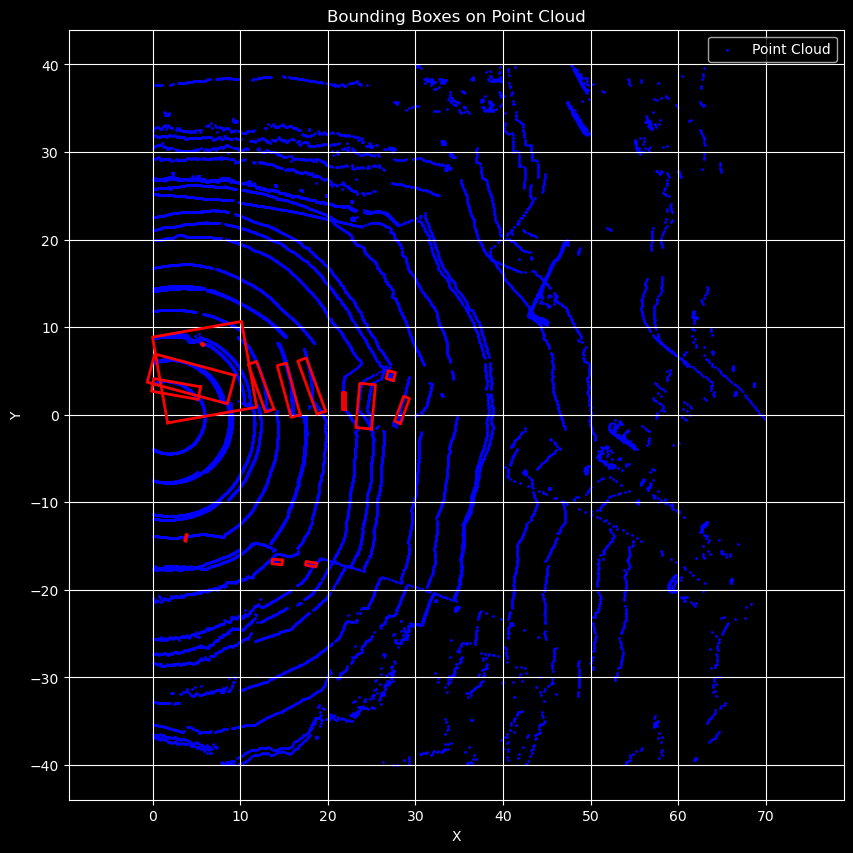

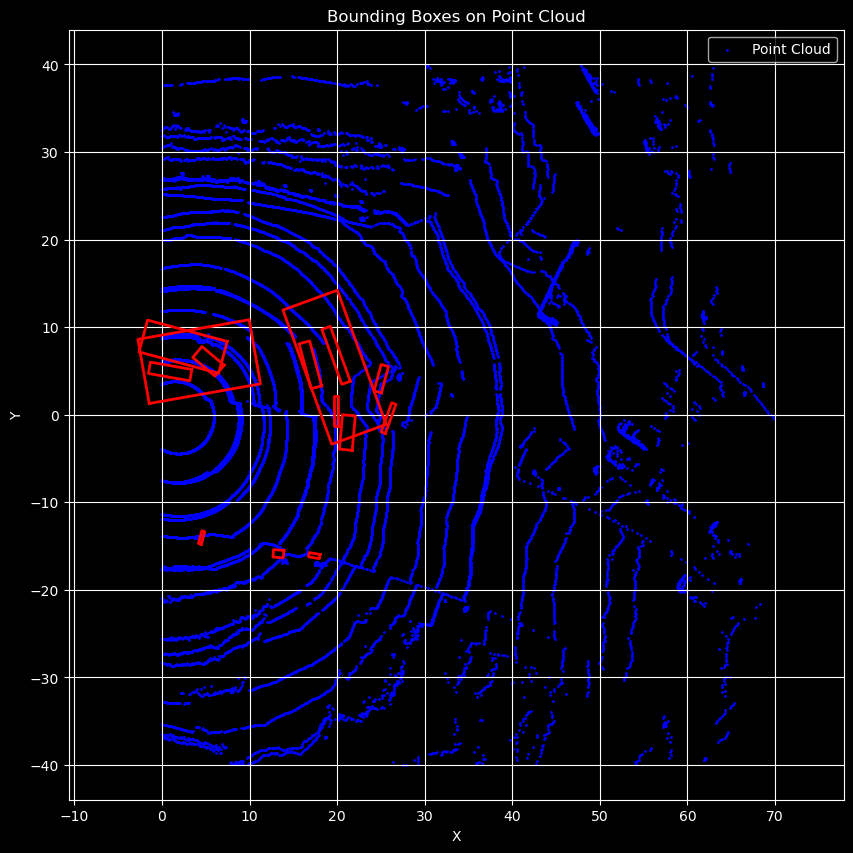

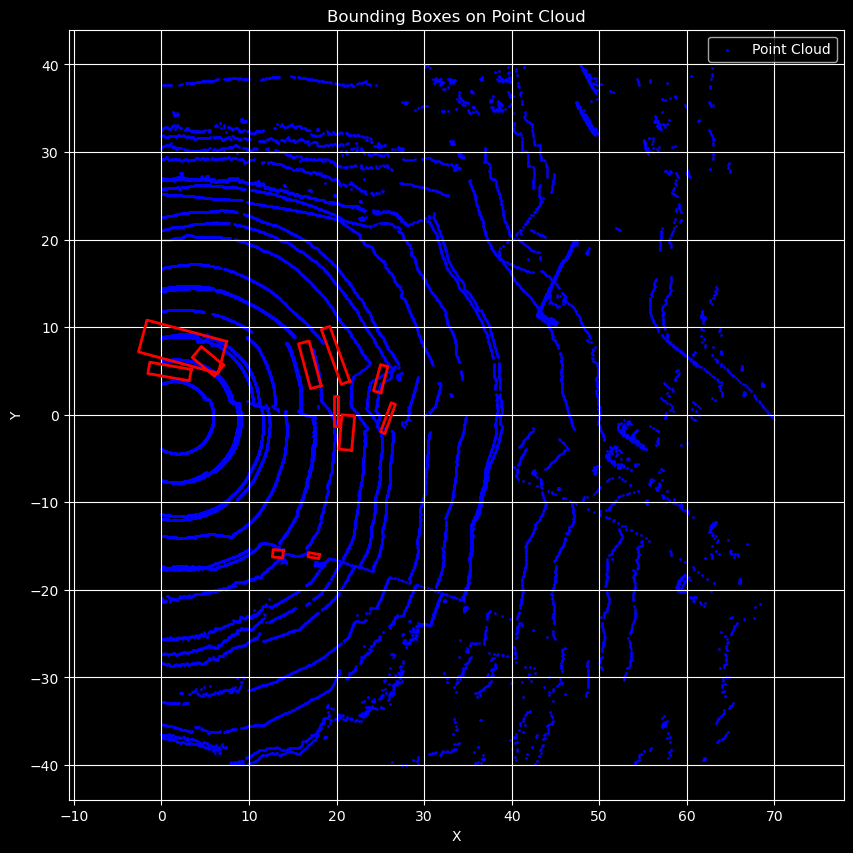

In [49]:
plot_bboxes_on_point_cloud(filter_roi(points), pseudo_labels_corners)
plot_bboxes_on_point_cloud(filter_roi(points), refined_corners)
plot_bboxes_on_point_cloud(filter_roi(points), refined_corners2)